In [1]:
import json, os, sys

from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

import networkx as nx

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, accuracy_score

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
import utils
import result_helper
from app.algorithms import random_walk

from tqdm import tqdm

sns.set(style="whitegrid")

In [2]:
def generate_planted_partition_graph(k: int, n_per_cluster: int, proba_in: float, proba_out: float):
    sizes = [n_per_cluster] * k
    labels = [label for label, size in enumerate(sizes) for _ in range(size)]
    
    n_blocks = len(sizes)

    probability_matrix = np.ones(shape=(n_blocks, n_blocks)) * proba_out
    np.fill_diagonal(probability_matrix, proba_in)
    g = nx.stochastic_block_model(sizes=sizes, p=probability_matrix)
    adjacency_matrix = nx.to_numpy_matrix(g)
    
    return adjacency_matrix, labels

In [3]:
k = 10
n_per_cluster = 100
n_nodes = k * n_per_cluster

q = 0.2
# p = q + 0.3 + q/np.sqrt(k)
p = q + 0.3
p

0.5

Why $p > \frac{q}{\sqrt{k}}$?

- We need to $p$ to be larger than $q$.
- The gap $p - q$ depends on the number of clusters, i.e. $k$.
- We would expect that where are two clusters then the gap can be small.
- However, for larger $k$, the larger the gap.

$\frac{q}{\sqrt{k}}$ becomes smaller for larger values of $k$.

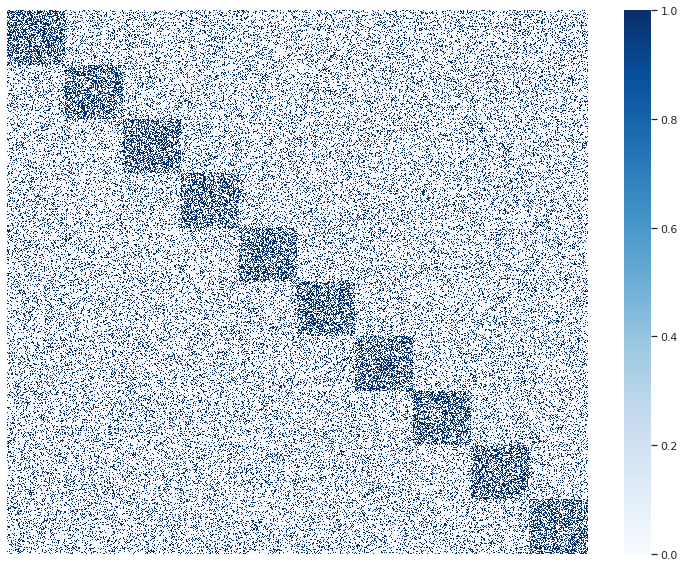

In [4]:
S, labels = generate_planted_partition_graph(k, 100, p, q)
fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(S, cmap="Blues", ax=ax)
ax.set_axis_off()

In [5]:
# available_colors = ['red', 'green', '#efefef']
# available_colors = sns.color_palette("hls", k)
# color_maps = [available_colors[label] for label in labels]

In [6]:
transition_matrix = (S / S.sum(axis=1).reshape(-1, 1)).T
n_points = transition_matrix.shape[0]

point_indices = np.arange(0, n_points)

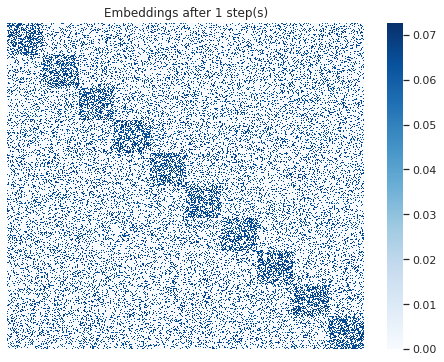

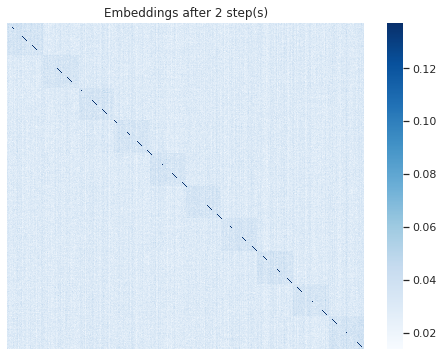

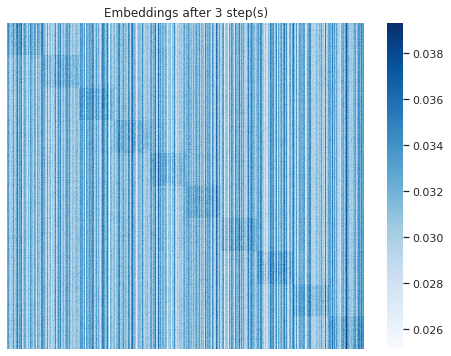

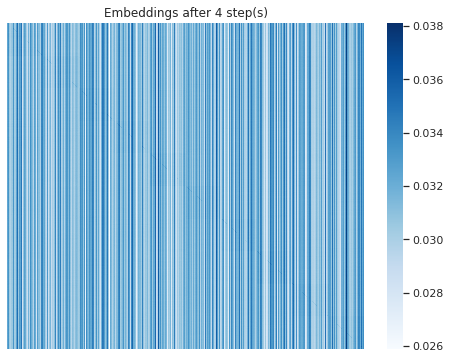

In [7]:
for n_steps in [1, 2, 3, 4]:
    embeddings = np.zeros(shape=(n_points, n_points))
    random_walk.compute_point_embeddings(
        transition_matrix=transition_matrix,
        point_indices=point_indices,
        n_steps=n_steps,
        embeddings=embeddings,
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(embeddings, cmap="Blues", ax=ax)
    ax.set_title(f"Embeddings after {n_steps} step(s)")
    ax.set_axis_off()

In [8]:
n_classes = np.unique(labels).shape[0]
print(f"Running k-Means with k={n_classes}")
kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(embeddings)

Running k-Means with k=10


KMeans(n_clusters=10)

In [9]:
df_results = pd.DataFrame({
    "noisy_label": labels,
    "true_label": labels,
    "cluster_label": kmeans.labels_
})
df_results.shape

(1000, 3)

In [10]:
df_results = utils.assign_labels_based_on_clusters(
    df_results=df_results,
    new_column_name="pred_label"
)
df_results.shape

(1000, 5)

In [11]:
accuracy_score(y_true=df_results["true_label"], y_pred=df_results["pred_label"])

1.0

### Measures of success

From: https://www.lirmm.fr/~sau/JCALM/Dieter.pdf

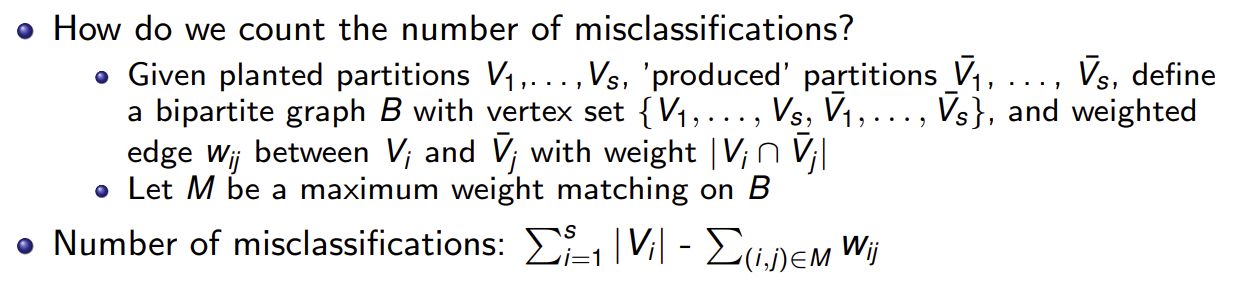

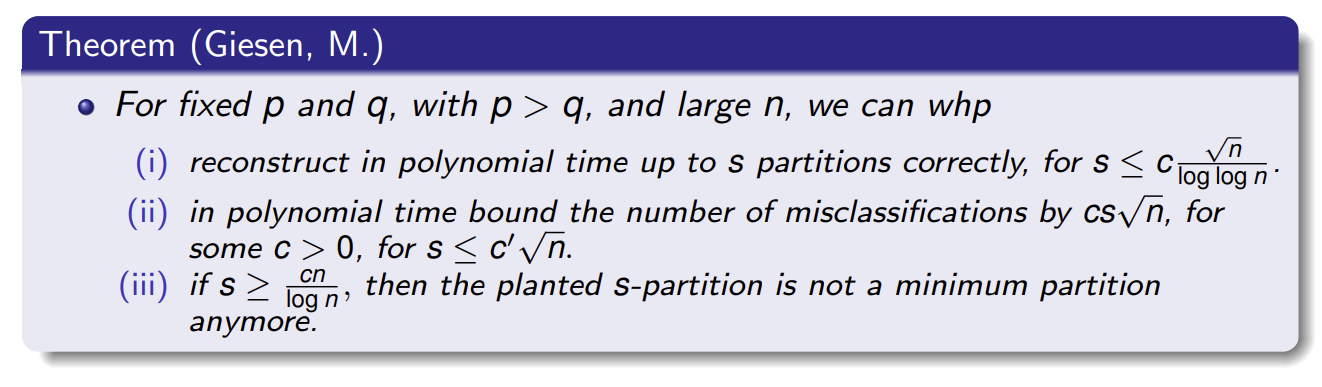

In [12]:
n_misclassifications = np.sum(df_results.true_label != df_results.pred_label)
n_misclassifications

0

## Single-step random walk on planted partition graphs with varying $p$ and $q$

In [13]:
def run_experiment():
    k = 10
    n_per_cluster = 100

    n_repetitions = 2
    q_range = [0.1, 0.2, 0.3, 0.4, 0.5]
    p_add_range = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45]
    n_iterations = n_repetitions * len(q_range) * len(p_add_range)

    results = []

    with tqdm(total=n_iterations) as pbar:
        for repetition in range(n_repetitions):
            for q in q_range:
                for p_add in p_add_range:
                    p = q + p_add
                    if p-q < 0:
                        pbar.update(1)
                        continue
                    A, labels = generate_planted_partition_graph(
                        k=k,
                        n_per_cluster=n_per_cluster,
                        proba_in=p,
                        proba_out=q,
                    )

                    n_nodes = A.shape[0]

                    transition_matrix = (A / A.sum(axis=1).reshape(-1, 1)).T
                    embeddings = np.zeros(shape=(n_nodes, n_nodes))
                    node_indices = np.arange(0, n_nodes)

                    random_walk.compute_point_embeddings(
                        transition_matrix=transition_matrix,
                        point_indices=node_indices,
                        n_steps=1,
                        embeddings=embeddings,
                    )

                    n_classes = np.unique(labels).shape[0]
                    kmeans = KMeans(n_clusters=n_classes)
                    kmeans.fit(embeddings)

                    df_results = pd.DataFrame({
                        "noisy_label": labels,
                        "true_label": labels,
                        "cluster_label": kmeans.labels_
                    })

                    df_results = utils.assign_labels_based_on_clusters(
                        df_results=df_results,
                        new_column_name="pred_label"
                    )

                    accuracy = accuracy_score(
                        y_true=df_results["true_label"],
                        y_pred=df_results["pred_label"]
                    )

                    results.append(dict(
                        repetition=repetition,
                        k=k,
                        p=p,
                        q=q,
                        p_add=p_add,
                        diff=p-q,
                        accuracy=accuracy
                    ))

                    pbar.update(1)
    df_results = pd.DataFrame(results)
    return df_results

In [14]:
results_path = Path("results/planted-partition-results.feather")
if results_path.exists():
    df_results = pd.read_feather(str(results_path))
else:
    df_results = run_experiment()
    df_results.to_feather(str(results_path))

In [15]:
def add_combined_mean_std(df: pd.DataFrame, attr: str, g_format: bool=False):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.2f} ({std:0.3f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)

In [17]:
df_grouped = df_results.groupby(["q", "p_add", "diff"])[["accuracy"]].agg(
    accuracy_mean=("accuracy", "mean"),
    accuracy_std=("accuracy", "std"),
).reset_index()
add_combined_mean_std(df=df_grouped, attr="accuracy")

In [18]:
df_grouped.reset_index().pivot(index=["p_add"], columns=["q"], values=["accuracy_mean_std"])

accuracy_mean_std                                            \
q                   0.1           0.2           0.3           0.4   
p_add                                                               
0.10       0.18 (0.011)  0.15 (0.007)  0.15 (0.004)  0.16 (0.003)   
0.15       0.35 (0.037)  0.20 (0.016)  0.17 (0.000)  0.16 (0.004)   
0.20       0.99 (0.003)  0.36 (0.066)  0.23 (0.006)  0.20 (0.027)   
0.25       1.00 (0.000)  1.00 (0.001)  0.74 (0.083)  0.49 (0.165)   
0.30       1.00 (0.000)  1.00 (0.001)  1.00 (0.001)  1.00 (0.001)   
0.35       1.00 (0.000)  1.00 (0.000)  1.00 (0.000)  1.00 (0.000)   
0.40       1.00 (0.000)  1.00 (0.000)  1.00 (0.000)  1.00 (0.000)   
0.45       1.00 (0.000)  1.00 (0.000)  1.00 (0.000)  1.00 (0.000)   

                     
q               0.5  
p_add                
0.10   0.15 (0.012)  
0.15   0.16 (0.012)  
0.20   0.21 (0.004)  
0.25   0.34 (0.016)  
0.30   0.94 (0.074)  
0.35   0.95 (0.071)  
0.40   1.00 (0.000)  
0.45   1.00 (0.000)